In [15]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import torchvision.models as models
# This is for the progress bar.
from tqdm import tqdm
import seaborn as sns

In [16]:
labels_dataframe = pd.read_csv('input/classify-leaves/train.csv')
labels_dataframe.head(5)

,image,label
0,images/0.jpg,maclura_pomifera
1,images/1.jpg,maclura_pomifera
2,images/2.jpg,maclura_pomifera
3,images/3.jpg,maclura_pomifera
4,images/4.jpg,maclura_pomifera


In [17]:
labels_dataframe.describe()

,image,label
count,18353,18353
unique,18353,176
top,images/0.jpg,maclura_pomifera
freq,1,353


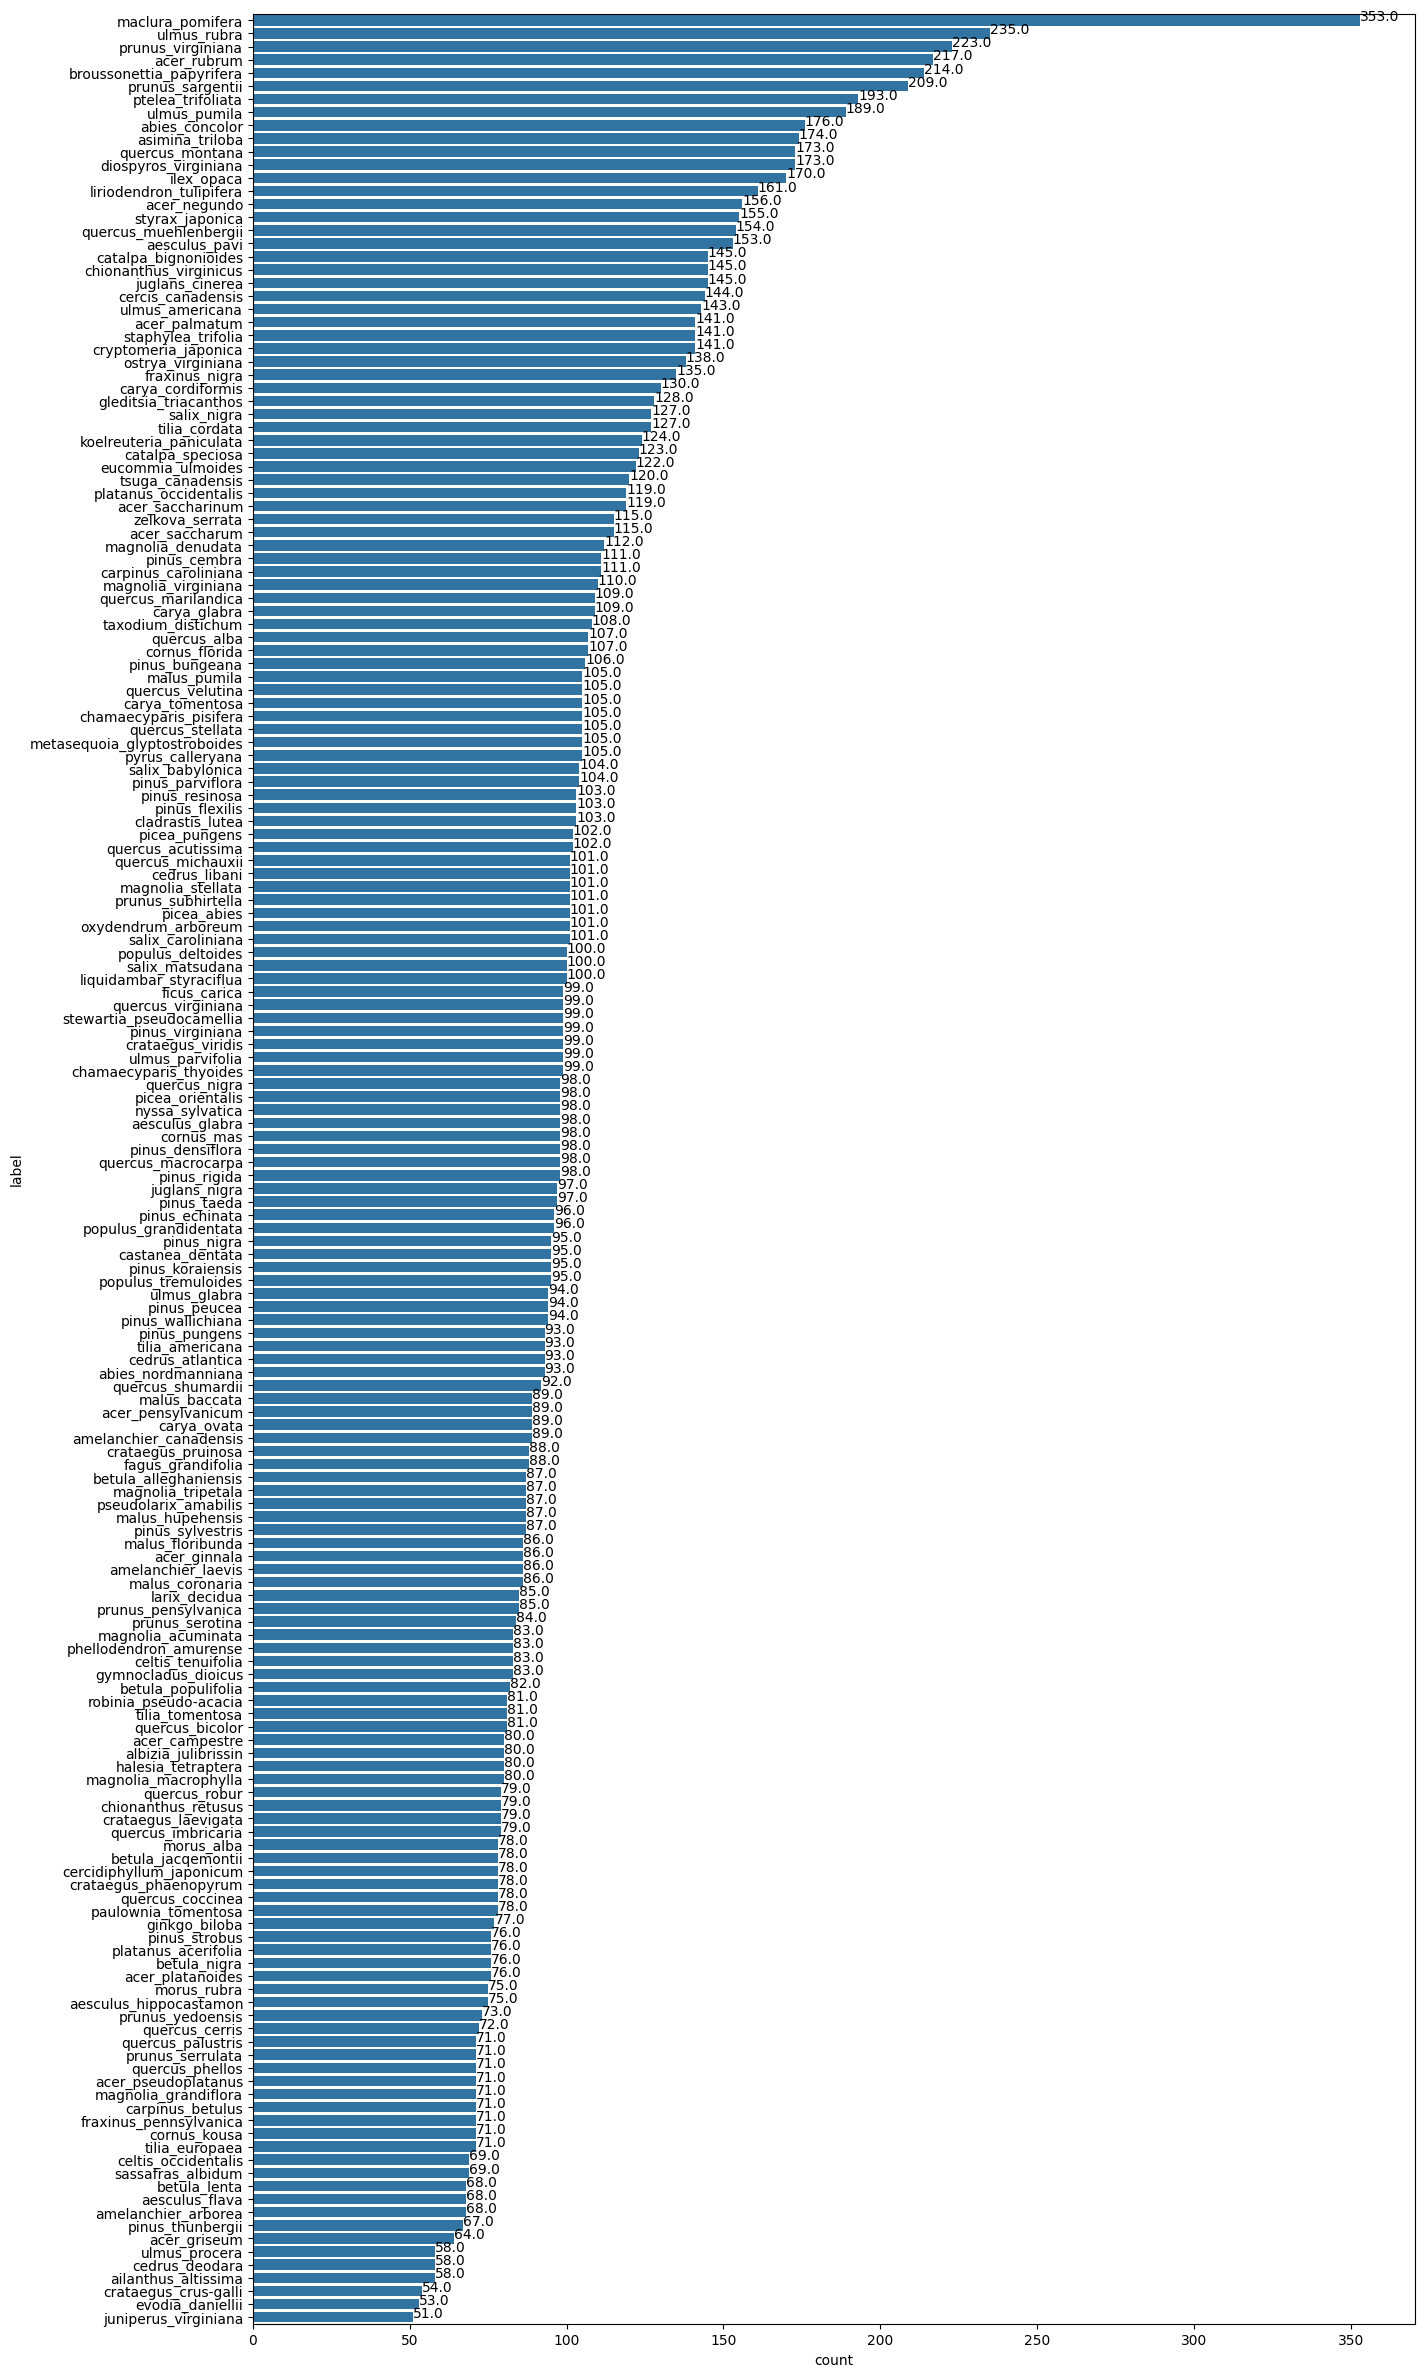

In [18]:
def barw(ax): 
    
    for p in ax.patches:
        val = p.get_width() #height of the bar
        x = p.get_x()+ p.get_width() # x- position 
        y = p.get_y() + p.get_height()/2 #y-position
        ax.annotate(round(val,2),(x,y))
        
#finding top leaves

plt.figure(figsize = (15,30))
ax0 =sns.countplot(y=labels_dataframe['label'],order=labels_dataframe['label'].value_counts().index)
barw(ax0)
plt.show()

In [19]:
# 把label文件排个序
leaves_labels = sorted(list(set(labels_dataframe['label'])))
n_classes = len(leaves_labels)
print(n_classes)
leaves_labels[:10]

176


['abies_concolor',
 'abies_nordmanniana',
 'acer_campestre',
 'acer_ginnala',
 'acer_griseum',
 'acer_negundo',
 'acer_palmatum',
 'acer_pensylvanicum',
 'acer_platanoides',
 'acer_pseudoplatanus']

In [20]:
# 把label转成对应的数字
class_to_num = dict(zip(leaves_labels, range(n_classes)))
class_to_num

{'abies_concolor': 0,
 'abies_nordmanniana': 1,
 'acer_campestre': 2,
 'acer_ginnala': 3,
 'acer_griseum': 4,
 'acer_negundo': 5,
 'acer_palmatum': 6,
 'acer_pensylvanicum': 7,
 'acer_platanoides': 8,
 'acer_pseudoplatanus': 9,
 'acer_rubrum': 10,
 'acer_saccharinum': 11,
 'acer_saccharum': 12,
 'aesculus_flava': 13,
 'aesculus_glabra': 14,
 'aesculus_hippocastamon': 15,
 'aesculus_pavi': 16,
 'ailanthus_altissima': 17,
 'albizia_julibrissin': 18,
 'amelanchier_arborea': 19,
 'amelanchier_canadensis': 20,
 'amelanchier_laevis': 21,
 'asimina_triloba': 22,
 'betula_alleghaniensis': 23,
 'betula_jacqemontii': 24,
 'betula_lenta': 25,
 'betula_nigra': 26,
 'betula_populifolia': 27,
 'broussonettia_papyrifera': 28,
 'carpinus_betulus': 29,
 'carpinus_caroliniana': 30,
 'carya_cordiformis': 31,
 'carya_glabra': 32,
 'carya_ovata': 33,
 'carya_tomentosa': 34,
 'castanea_dentata': 35,
 'catalpa_bignonioides': 36,
 'catalpa_speciosa': 37,
 'cedrus_atlantica': 38,
 'cedrus_deodara': 39,
 'cedru

In [21]:
# 再转换回来，方便最后预测的时候使用
num_to_class = {v : k for k, v in class_to_num.items()}

In [22]:
# 继承pytorch的dataset，创建自己的
class LeavesData(Dataset):
    def __init__(self, csv_path, file_path, mode='train', valid_ratio=0.2, resize_height=256, resize_width=256):
        """
        Args:
            csv_path (string): csv 文件路径
            img_path (string): 图像文件所在路径
            mode (string): 训练模式还是测试模式
            valid_ratio (float): 验证集比例
        """
        
        # 需要调整后的照片尺寸，我这里每张图片的大小尺寸不一致#
        self.resize_height = resize_height
        self.resize_width = resize_width

        self.file_path = file_path
        self.mode = mode

        # 读取 csv 文件
        # 利用pandas读取csv文件
        self.data_info = pd.read_csv(csv_path, header=None)  #header=None是去掉表头部分
        # 计算 length
        self.data_len = len(self.data_info.index) - 1
        self.train_len = int(self.data_len * (1 - valid_ratio))
        
        if mode == 'train':
            # 第一列包含图像文件的名称
            self.train_image = np.asarray(self.data_info.iloc[1:self.train_len, 0])  #self.data_info.iloc[1:,0]表示读取第一列，从第二行开始到train_len
            # 第二列是图像的 label
            self.train_label = np.asarray(self.data_info.iloc[1:self.train_len, 1])
            self.image_arr = self.train_image 
            self.label_arr = self.train_label
        elif mode == 'valid':
            self.valid_image = np.asarray(self.data_info.iloc[self.train_len:, 0])  
            self.valid_label = np.asarray(self.data_info.iloc[self.train_len:, 1])
            self.image_arr = self.valid_image
            self.label_arr = self.valid_label
        elif mode == 'test':
            self.test_image = np.asarray(self.data_info.iloc[1:, 0])
            self.image_arr = self.test_image
            
        self.real_len = len(self.image_arr)

        print('Finished reading the {} set of Leaves Dataset ({} samples found)'
              .format(mode, self.real_len))

    def __getitem__(self, index):
        # 从 image_arr中得到索引对应的文件名
        single_image_name = self.image_arr[index]

        # 读取图像文件
        img_as_img = Image.open(self.file_path + single_image_name)

        #如果需要将RGB三通道的图片转换成灰度图片可参考下面两行
#         if img_as_img.mode != 'L':
#             img_as_img = img_as_img.convert('L')

        #设置好需要转换的变量，还可以包括一系列的nomarlize等等操作
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=0.5),   #随机水平翻转 选择一个概率
                transforms.ToTensor()
            ])
        else:
            # valid和test不做数据增强
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor()
            ])
        
        img_as_img = transform(img_as_img)
        
        if self.mode == 'test':
            return img_as_img
        else:
            # 得到图像的 string label
            label = self.label_arr[index]
            # number label
            number_label = class_to_num[label]

            return img_as_img, number_label  #返回每一个index对应的图片数据和对应的label

    def __len__(self):
        return self.real_len

In [27]:
train_path = 'input/classify-leaves/train.csv'
test_path = 'input/classify-leaves/test.csv'
img_path = 'autodl-tmp/'

train_dataset = LeavesData(train_path, img_path, mode='train')
val_dataset = LeavesData(train_path, img_path, mode='valid')
test_dataset = LeavesData(test_path, img_path, mode='test')
print(train_dataset)
print(val_dataset)
print(test_dataset)

Finished reading the train set of Leaves Dataset (14681 samples found)
Finished reading the valid set of Leaves Dataset (3672 samples found)
Finished reading the test set of Leaves Dataset (8800 samples found)


In [28]:
# 定义data loader
train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=8, 
        shuffle=False,
        num_workers=5
    )

val_loader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=8, 
        shuffle=False,
        num_workers=5
    )
test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=8, 
        shuffle=False,
        num_workers=5
    )

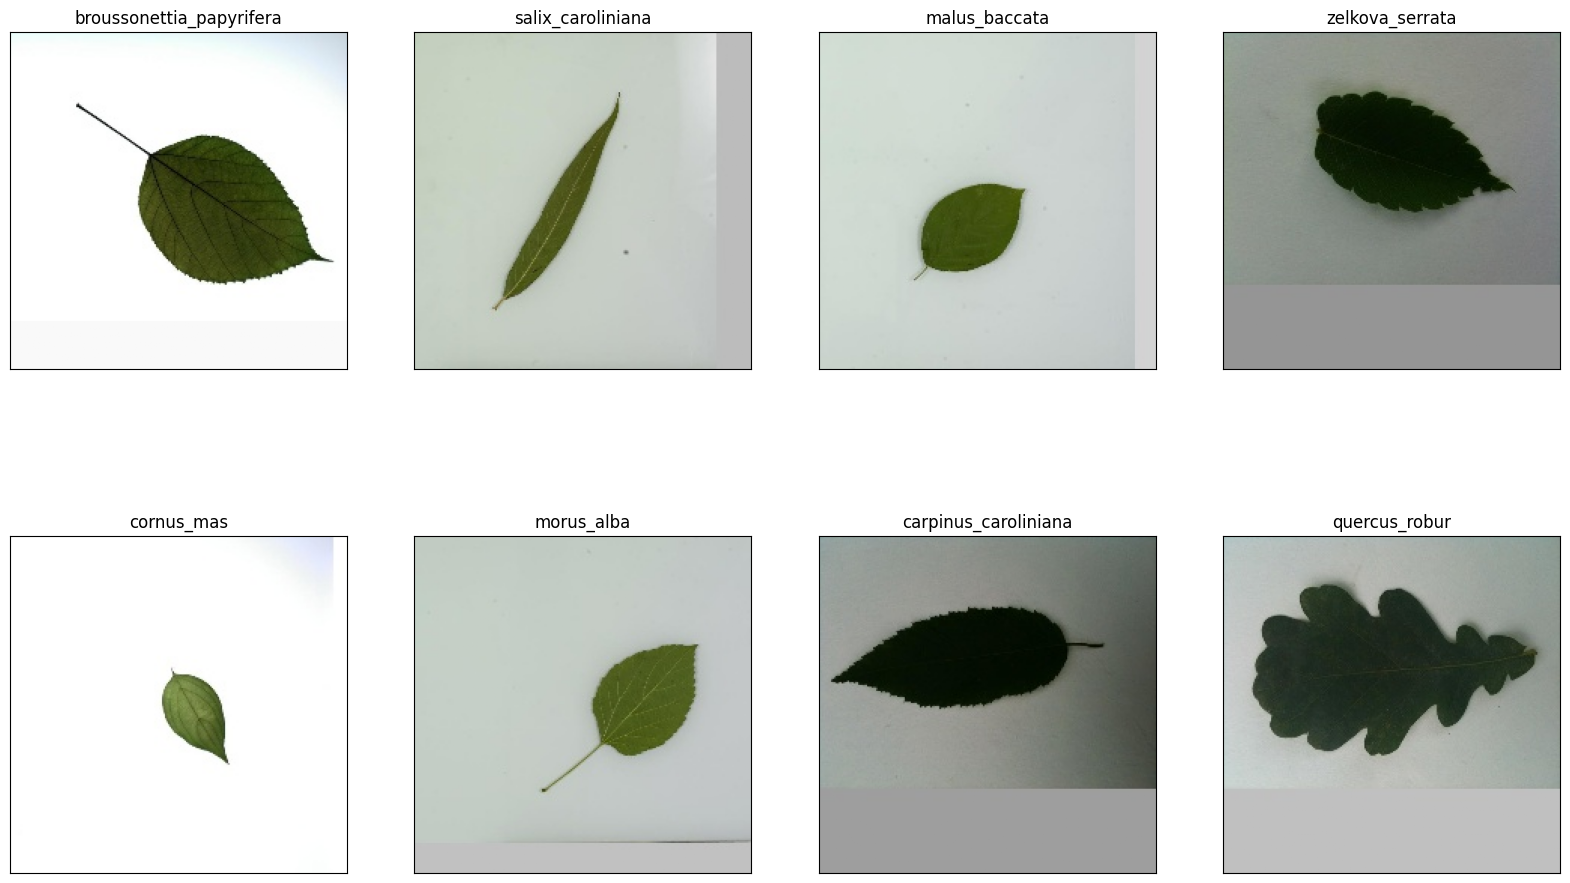

In [29]:
# 给大家展示一下数据长啥样
def im_convert(tensor):
    """ 展示数据"""
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image.clip(0, 1)

    return image

fig=plt.figure(figsize=(20, 12))
columns = 4
rows = 2

dataiter = iter(val_loader)
inputs, classes = next(dataiter)

for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    ax.set_title(num_to_class[int(classes[idx])])
    plt.imshow(im_convert(inputs[idx]))
plt.show()

In [30]:
# 看一下是在cpu还是GPU上
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

device = get_device()
print(device)

cuda


In [31]:
# 是否要冻住模型的前面一些层
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        model = model
        for param in model.parameters():
            param.requires_grad = False
# resnet34模型
def res_model(num_classes, feature_extract = False, use_pretrained=True):

    model_ft = models.resnet34(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, num_classes))

    return model_ft

In [32]:
# 超参数
learning_rate = 3e-4
weight_decay = 1e-3
num_epoch = 50
model_path = './pre_res_model.ckpt'

In [33]:
# Initialize a model, and put it on the device specified.
model = res_model(176)
model = model.to(device)
model.device = device
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

# The number of training epochs.
n_epochs = num_epoch

best_acc = 0.0
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train() 
    # These are used to record information in training.
    train_loss = []
    train_accs = []
    # Iterate the training set by batches.
    for batch in tqdm(train_loader):
        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)
        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)
        
        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()
        # Compute the gradients for parameters.
        loss.backward()
        # Update the parameters with computed gradients.
        optimizer.step()
        
        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    
    
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    
    # Iterate the validation set by batches.
    for batch in tqdm(val_loader):
        imgs, labels = batch
        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))
            
        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        
    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    
    # if the model improves, save a checkpoint at this epoch
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), model_path)
        print('saving model with acc {:.3f}'.format(best_acc))

/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:09<00:00, 9.20MB/s]
100%|██████████| 1836/1836 [00:47<00:00, 38.40it/s]


[ Train | 001/050 ] loss = 2.86283, acc = 0.30059


100%|██████████| 459/459 [00:03<00:00, 116.97it/s]


[ Valid | 001/050 ] loss = 1.85871, acc = 0.46623
saving model with acc 0.466


100%|██████████| 1836/1836 [00:48<00:00, 37.56it/s]


[ Train | 002/050 ] loss = 1.63507, acc = 0.52655


100%|██████████| 459/459 [00:03<00:00, 116.80it/s]


[ Valid | 002/050 ] loss = 1.51757, acc = 0.54139
saving model with acc 0.541


100%|██████████| 1836/1836 [00:48<00:00, 37.64it/s]


[ Train | 003/050 ] loss = 1.25437, acc = 0.63024


100%|██████████| 459/459 [00:03<00:00, 119.17it/s]


[ Valid | 003/050 ] loss = 1.14983, acc = 0.65251
saving model with acc 0.653


100%|██████████| 1836/1836 [00:49<00:00, 37.17it/s]


[ Train | 004/050 ] loss = 1.02950, acc = 0.69465


100%|██████████| 459/459 [00:04<00:00, 106.84it/s]


[ Valid | 004/050 ] loss = 1.46500, acc = 0.57271


100%|██████████| 1836/1836 [00:48<00:00, 37.90it/s]


[ Train | 005/050 ] loss = 0.87735, acc = 0.73829


100%|██████████| 459/459 [00:04<00:00, 113.93it/s]


[ Valid | 005/050 ] loss = 1.11504, acc = 0.66612
saving model with acc 0.666


100%|██████████| 1836/1836 [00:49<00:00, 37.23it/s]


[ Train | 006/050 ] loss = 0.75633, acc = 0.78009


100%|██████████| 459/459 [00:03<00:00, 117.60it/s]


[ Valid | 006/050 ] loss = 1.00674, acc = 0.71024
saving model with acc 0.710


100%|██████████| 1836/1836 [00:49<00:00, 37.12it/s]


[ Train | 007/050 ] loss = 0.67938, acc = 0.80229


100%|██████████| 459/459 [00:04<00:00, 108.13it/s]


[ Valid | 007/050 ] loss = 1.27041, acc = 0.66394


100%|██████████| 1836/1836 [00:48<00:00, 37.91it/s]


[ Train | 008/050 ] loss = 0.59777, acc = 0.82884


100%|██████████| 459/459 [00:04<00:00, 110.89it/s]


[ Valid | 008/050 ] loss = 0.95303, acc = 0.72712
saving model with acc 0.727


100%|██████████| 1836/1836 [00:49<00:00, 37.04it/s]


[ Train | 009/050 ] loss = 0.56083, acc = 0.84116


100%|██████████| 459/459 [00:04<00:00, 112.94it/s]


[ Valid | 009/050 ] loss = 0.83430, acc = 0.75218
saving model with acc 0.752


100%|██████████| 1836/1836 [00:49<00:00, 37.30it/s]


[ Train | 010/050 ] loss = 0.49348, acc = 0.86247


100%|██████████| 459/459 [00:04<00:00, 113.69it/s]


[ Valid | 010/050 ] loss = 0.81848, acc = 0.76362
saving model with acc 0.764


100%|██████████| 1836/1836 [00:48<00:00, 37.48it/s]


[ Train | 011/050 ] loss = 0.47321, acc = 0.87139


100%|██████████| 459/459 [00:04<00:00, 112.62it/s]


[ Valid | 011/050 ] loss = 0.81841, acc = 0.76389
saving model with acc 0.764


100%|██████████| 1836/1836 [00:49<00:00, 36.98it/s]


[ Train | 012/050 ] loss = 0.44966, acc = 0.87657


100%|██████████| 459/459 [00:03<00:00, 115.88it/s]


[ Valid | 012/050 ] loss = 0.88106, acc = 0.74292


100%|██████████| 1836/1836 [00:49<00:00, 37.05it/s]


[ Train | 013/050 ] loss = 0.40959, acc = 0.88903


100%|██████████| 459/459 [00:03<00:00, 119.22it/s]


[ Valid | 013/050 ] loss = 0.91200, acc = 0.73693


100%|██████████| 1836/1836 [00:49<00:00, 37.42it/s]


[ Train | 014/050 ] loss = 0.39354, acc = 0.89338


100%|██████████| 459/459 [00:04<00:00, 113.17it/s]


[ Valid | 014/050 ] loss = 0.76413, acc = 0.78431
saving model with acc 0.784


100%|██████████| 1836/1836 [00:50<00:00, 36.16it/s]


[ Train | 015/050 ] loss = 0.37365, acc = 0.90196


100%|██████████| 459/459 [00:04<00:00, 113.62it/s]


[ Valid | 015/050 ] loss = 0.91161, acc = 0.74619


100%|██████████| 1836/1836 [00:49<00:00, 37.01it/s]


[ Train | 016/050 ] loss = 0.36251, acc = 0.90332


100%|██████████| 459/459 [00:04<00:00, 114.16it/s]


[ Valid | 016/050 ] loss = 0.72525, acc = 0.79167
saving model with acc 0.792


100%|██████████| 1836/1836 [00:47<00:00, 38.54it/s]


[ Train | 017/050 ] loss = 0.34496, acc = 0.91340


100%|██████████| 459/459 [00:04<00:00, 112.48it/s]


[ Valid | 017/050 ] loss = 0.80568, acc = 0.77723


100%|██████████| 1836/1836 [00:47<00:00, 38.50it/s]


[ Train | 018/050 ] loss = 0.32758, acc = 0.91551


100%|██████████| 459/459 [00:03<00:00, 115.06it/s]


[ Valid | 018/050 ] loss = 0.76785, acc = 0.78105


100%|██████████| 1836/1836 [00:48<00:00, 37.58it/s]


[ Train | 019/050 ] loss = 0.32076, acc = 0.92116


100%|██████████| 459/459 [00:04<00:00, 105.38it/s]


[ Valid | 019/050 ] loss = 0.81440, acc = 0.77042


100%|██████████| 1836/1836 [00:49<00:00, 37.19it/s]


[ Train | 020/050 ] loss = 0.30301, acc = 0.92586


100%|██████████| 459/459 [00:04<00:00, 113.00it/s]


[ Valid | 020/050 ] loss = 0.84331, acc = 0.76825


100%|██████████| 1836/1836 [00:49<00:00, 36.86it/s]


[ Train | 021/050 ] loss = 0.30449, acc = 0.92456


100%|██████████| 459/459 [00:04<00:00, 110.58it/s]


[ Valid | 021/050 ] loss = 0.65860, acc = 0.80719
saving model with acc 0.807


100%|██████████| 1836/1836 [00:48<00:00, 37.89it/s]


[ Train | 022/050 ] loss = 0.29215, acc = 0.92702


100%|██████████| 459/459 [00:03<00:00, 116.37it/s]


[ Valid | 022/050 ] loss = 0.79700, acc = 0.77859


100%|██████████| 1836/1836 [00:49<00:00, 37.10it/s]


[ Train | 023/050 ] loss = 0.28993, acc = 0.92838


100%|██████████| 459/459 [00:04<00:00, 112.49it/s]


[ Valid | 023/050 ] loss = 0.73801, acc = 0.79221


100%|██████████| 1836/1836 [00:50<00:00, 36.70it/s]


[ Train | 024/050 ] loss = 0.28799, acc = 0.92967


100%|██████████| 459/459 [00:04<00:00, 114.47it/s]


[ Valid | 024/050 ] loss = 0.67138, acc = 0.80419


100%|██████████| 1836/1836 [00:50<00:00, 36.37it/s]


[ Train | 025/050 ] loss = 0.27389, acc = 0.93512


100%|██████████| 459/459 [00:03<00:00, 115.19it/s]


[ Valid | 025/050 ] loss = 1.25167, acc = 0.67865


100%|██████████| 1836/1836 [00:50<00:00, 36.68it/s]


[ Train | 026/050 ] loss = 0.27149, acc = 0.93382


100%|██████████| 459/459 [00:03<00:00, 118.79it/s]


[ Valid | 026/050 ] loss = 0.79098, acc = 0.78731


100%|██████████| 1836/1836 [00:50<00:00, 36.41it/s]


[ Train | 027/050 ] loss = 0.26747, acc = 0.93675


100%|██████████| 459/459 [00:03<00:00, 116.72it/s]


[ Valid | 027/050 ] loss = 0.69325, acc = 0.80528


100%|██████████| 1836/1836 [00:50<00:00, 36.38it/s]


[ Train | 028/050 ] loss = 0.25960, acc = 0.93941


100%|██████████| 459/459 [00:03<00:00, 116.78it/s]


[ Valid | 028/050 ] loss = 0.78293, acc = 0.78295


100%|██████████| 1836/1836 [00:49<00:00, 36.77it/s]


[ Train | 029/050 ] loss = 0.25699, acc = 0.94090


100%|██████████| 459/459 [00:03<00:00, 117.57it/s]


[ Valid | 029/050 ] loss = 0.72869, acc = 0.79303


100%|██████████| 1836/1836 [00:49<00:00, 37.39it/s]


[ Train | 030/050 ] loss = 0.24778, acc = 0.94444


100%|██████████| 459/459 [00:03<00:00, 116.91it/s]


[ Valid | 030/050 ] loss = 0.84630, acc = 0.77887


100%|██████████| 1836/1836 [00:49<00:00, 37.46it/s]


[ Train | 031/050 ] loss = 0.24187, acc = 0.94424


100%|██████████| 459/459 [00:03<00:00, 118.20it/s]


[ Valid | 031/050 ] loss = 0.99776, acc = 0.72168


100%|██████████| 1836/1836 [00:48<00:00, 37.57it/s]


[ Train | 032/050 ] loss = 0.24898, acc = 0.94254


100%|██████████| 459/459 [00:04<00:00, 110.63it/s]


[ Valid | 032/050 ] loss = 0.76913, acc = 0.78840


100%|██████████| 1836/1836 [00:49<00:00, 36.90it/s]


[ Train | 033/050 ] loss = 0.25539, acc = 0.94043


100%|██████████| 459/459 [00:04<00:00, 113.33it/s]


[ Valid | 033/050 ] loss = 0.72259, acc = 0.80093


100%|██████████| 1836/1836 [00:49<00:00, 37.42it/s]


[ Train | 034/050 ] loss = 0.22879, acc = 0.94914


100%|██████████| 459/459 [00:03<00:00, 117.65it/s]


[ Valid | 034/050 ] loss = 0.71172, acc = 0.79984


100%|██████████| 1836/1836 [00:49<00:00, 37.04it/s]


[ Train | 035/050 ] loss = 0.23860, acc = 0.94724


100%|██████████| 459/459 [00:03<00:00, 115.02it/s]


[ Valid | 035/050 ] loss = 0.66578, acc = 0.80991
saving model with acc 0.810


100%|██████████| 1836/1836 [00:50<00:00, 36.04it/s]


[ Train | 036/050 ] loss = 0.23072, acc = 0.94860


100%|██████████| 459/459 [00:03<00:00, 116.02it/s]


[ Valid | 036/050 ] loss = 0.71755, acc = 0.79684


100%|██████████| 1836/1836 [00:49<00:00, 36.99it/s]


[ Train | 037/050 ] loss = 0.22618, acc = 0.94771


100%|██████████| 459/459 [00:04<00:00, 113.34it/s]


[ Valid | 037/050 ] loss = 0.80871, acc = 0.78431


100%|██████████| 1836/1836 [00:49<00:00, 37.00it/s]


[ Train | 038/050 ] loss = 0.23130, acc = 0.94839


100%|██████████| 459/459 [00:04<00:00, 112.58it/s]


[ Valid | 038/050 ] loss = 0.73226, acc = 0.79493


100%|██████████| 1836/1836 [00:49<00:00, 37.06it/s]


[ Train | 039/050 ] loss = 0.22311, acc = 0.94996


100%|██████████| 459/459 [00:03<00:00, 115.22it/s]


[ Valid | 039/050 ] loss = 0.81883, acc = 0.77587


100%|██████████| 1836/1836 [00:49<00:00, 37.10it/s]


[ Train | 040/050 ] loss = 0.22021, acc = 0.95091


100%|██████████| 459/459 [00:03<00:00, 116.19it/s]


[ Valid | 040/050 ] loss = 0.73194, acc = 0.80310


100%|██████████| 1836/1836 [00:49<00:00, 37.03it/s]


[ Train | 041/050 ] loss = 0.21961, acc = 0.95200


100%|██████████| 459/459 [00:04<00:00, 112.70it/s]


[ Valid | 041/050 ] loss = 0.68259, acc = 0.81127
saving model with acc 0.811


100%|██████████| 1836/1836 [00:49<00:00, 36.90it/s]


[ Train | 042/050 ] loss = 0.21074, acc = 0.95581


100%|██████████| 459/459 [00:03<00:00, 115.14it/s]


[ Valid | 042/050 ] loss = 0.82759, acc = 0.77124


100%|██████████| 1836/1836 [00:47<00:00, 38.52it/s]


[ Train | 043/050 ] loss = 0.22657, acc = 0.94955


100%|██████████| 459/459 [00:03<00:00, 115.62it/s]


[ Valid | 043/050 ] loss = 0.67651, acc = 0.81727
saving model with acc 0.817


100%|██████████| 1836/1836 [00:49<00:00, 37.25it/s]


[ Train | 044/050 ] loss = 0.20973, acc = 0.95479


100%|██████████| 459/459 [00:03<00:00, 119.88it/s]


[ Valid | 044/050 ] loss = 0.65378, acc = 0.81917
saving model with acc 0.819


100%|██████████| 1836/1836 [00:50<00:00, 36.67it/s]


[ Train | 045/050 ] loss = 0.21103, acc = 0.95452


100%|██████████| 459/459 [00:03<00:00, 116.80it/s]


[ Valid | 045/050 ] loss = 0.67659, acc = 0.81373


100%|██████████| 1836/1836 [00:49<00:00, 36.82it/s]


[ Train | 046/050 ] loss = 0.20632, acc = 0.95520


100%|██████████| 459/459 [00:04<00:00, 113.91it/s]


[ Valid | 046/050 ] loss = 0.99885, acc = 0.72985


100%|██████████| 1836/1836 [00:49<00:00, 36.84it/s]


[ Train | 047/050 ] loss = 0.21092, acc = 0.95343


100%|██████████| 459/459 [00:03<00:00, 118.10it/s]


[ Valid | 047/050 ] loss = 0.68963, acc = 0.79630


100%|██████████| 1836/1836 [00:49<00:00, 36.93it/s]


[ Train | 048/050 ] loss = 0.20988, acc = 0.95330


100%|██████████| 459/459 [00:03<00:00, 114.81it/s]


[ Valid | 048/050 ] loss = 0.63958, acc = 0.81672


100%|██████████| 1836/1836 [00:48<00:00, 37.96it/s]


[ Train | 049/050 ] loss = 0.20163, acc = 0.95711


100%|██████████| 459/459 [00:04<00:00, 114.09it/s]


[ Valid | 049/050 ] loss = 0.65891, acc = 0.81536


100%|██████████| 1836/1836 [00:49<00:00, 37.15it/s]


[ Train | 050/050 ] loss = 0.19711, acc = 0.95935


100%|██████████| 459/459 [00:03<00:00, 117.89it/s]

[ Valid | 050/050 ] loss = 0.70709, acc = 0.80528
